In [1]:
import sys
path ='/home/ashesh.ashesh/code/Disentangle'
if path in sys.path:
    sys.path.remove(path)
sys.path

['/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python313.zip',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13',
 '/home/ashesh.ashesh/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/lib-dynload',
 '',
 '/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages',
 '/localscratch/code/FinetuneSplit/src',
 '__editable__.semanticunmix-0.1.0.finder.__path_hook__']

In [2]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import numpy as np
import seaborn as sns

from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
from disentangle.core.psnr import PSNR
from disentangle.core.psnr import RangeInvariantPsnr

from finetunesplit.forward_operator_parameters import get_forward_operator_parameters
from finetunesplit.posterior_sampler import get_transform_obj, PosteriorSampler, get_input_transform_obj
from finetunesplit.asymmetric_transforms import TransformEnum
from finetunesplit.calibration.calibration_coverage import compute_for_one_batch
from finetunesplit.calibration.grid_search import grid_search
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.calibration.grid_search import get_percentage_occurance



In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run ./nb_core/disentangle_imports.ipynb

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_4670/785086027.py:12: SyntaxWarning: invalid escape sequence '\d'
  elif (re.match( 'lin-jug-\d{2}',nodename) or re.match( 'gnode\d{2}',nodename) or
/tmp/ipykernel_4670/785086027.py:12: SyntaxWarning: invalid escape sequence '\d'
  elif (re.match( 'lin-jug-\d{2}',nodename) or re.match( 'gnode\d{2}',nodename) or
/tmp/ipykernel_4670/785086027.py:13: SyntaxWarning: invalid escape sequence '\d'
  re.match( 'lin-jug-m-\d{2}',nodename) or re.match( 'lin-jug-l-\d{2}',nodename)) or nodename.startswith('lin-jug-'):
/tmp/ipykernel_4670/785086027.py:13: SyntaxWarning: invalid escape sequence '\d'
  re.match( 'lin-jug-m-\d{2}',nodename) or re.match( 'lin-jug-l-\d{2}',nodename)) or nodename.startswith('lin-jug-'):


DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [5]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [ ]:

# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/14"
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12"
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M29-S0-L0/8'
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M3-S0-L0/2'
ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D24-M3-S0-L0/11'
assert os.path.exists(ckpt_dir)

image_size_for_grid_centers = None
custom_image_size = None
data_t_list = None #[0,1,2]
tiling_mode = TilingMode.ShiftBoundary

batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'



# coverage parameters.
# correlation preserving transform
corr_pres_trans=True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.1
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 50
# error is computed from the first prediction
compute_error_from_first_prediction= True
k_forward_pass = 2
learn_noise_characteristics = True

k_prediction_mode = 'entire'
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = False
# apply input transforms to input.
with_inp_transforms = True
keep_original_input_fraction = 0.0
# when disable stochasticity is set to True, we pick the modes from the latent space
# instead of sampling from the distributions. But note that this also means that we get suboptimal prediction as well. To fix this, one may want to have two models.
disable_stochasticity = False

# this ensure that while we fit to 50 percentile, we pick the best fit on the basis of multiple percentiles and so is more robust.
enable_percentile_evaluation = True
# number of pixels to skip from each border while computing the error and variance
skip_pixels_err_var_computation = 0
background_quantile = 0.01



In [7]:
dtype = get_dtype(ckpt_dir)
dtype

24

In [8]:
assert k_prediction_mode in ['entire', 'only_transformed', 'only_first']

In [9]:
%run ./nb_core/config_loader.ipynb

data:
  alpha_level: Balanced
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 24
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  num_channels: 2
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  power_level: Low
  randomized_channels: false
  sampler_type: 0
  subdset_type: 2
  synthetic_gaussian_scale: null
  target_separate_normalization: true
  test_idx:
  - 0
  - 10
  train_aug_rotate: false
  trainig_datausage_fraction: 1.0
  uncorrelated_channel_probab: 0.5
  uncorrelated_channels: false
  use_one_mu_std: true
  val_grid_size: 32
  val_idx:
  - 2
  - 12
datadir: /group/jug/ashesh/data/pavia3_sequential_cropped/
exptname: 2509/D24-M3-S0-L0/11
git:
  branch: lyon_discriminator
  changedFiles:
  - disentangle/configs/pavia3_denoisplit.py
  latest_commit: ad0a837c5bf4974674319bf4f05fe13583ed3e76
  untracked_files: []
hos

In [10]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [11]:

# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if 'depth3D' in config.data and config.data.depth3D > 1:
        config.data.mode_3D = True
        config.model.mode_3D = True

    if 'start_alpha' in config.data:
        print('Disabling the mixing augmentation, if any')
        config.data.start_alpha = None
        config.data.end_alpha = None
        config.data.alpha_weighted_target = False
            
    # config.model.skip_nboundary_pixels_from_loss = None
    # if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
    #     config.model.n_levels = 4
    # # if config.data.sampler_type == SamplerType.NeighborSampler:
    #     config.data.sampler_type = SamplerType.DefaultSampler
    #     config.loss.loss_type = LossType.Elbo
    #     config.data.grid_size = config.data.image_size
    # # if 'ch1_fpath_list' in config.data:
    #     config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
    #     config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    # # if config.data.data_type == DataType.Pavia2VanillaSplitting:
    #     if 'channel_2_downscale_factor' not in config.data:
    #         config.data.channel_2_downscale_factor = 1
    # # if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
    #     config.model.init_channel_count = 64
    
    # if 'skip_receptive_field_loss_tokens' not in config.loss:
    #     config.loss.skip_receptive_field_loss_tokens = []
    
    # if dtype == DataType.HTIba1Ki67:
    #     config.data.subdset_type = SubDsetType.OnlyIba1P30
    #     config.data.empty_patch_replacement_enabled = False
    
    # if 'lowres_merge_type' not in config.model.encoder:
    #     config.model.encoder.lowres_merge_type = 0
    # if 'validtarget_random_fraction' in config.data:
    #     config.data.validtarget_random_fraction = None
    
    # if config.data.data_type == DataType.TwoDset:
    #     config.model.model_type = ModelType.LadderVae
    #     for key in config.data.dset1:
    #         config.data[key] = config.data.dset1[key]
    
    # if 'dump_kth_frame_prediction' in config.training:
    #     config.training.dump_kth_frame_prediction = None

    # # if 'input_is_sum' not in config.data:
    #     config.data.input_is_sum = False

In [12]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
# elif dtype == DataType.ExpansionMicroscopyMitoTub:
    # data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/datafiles/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential_cropped/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/20240531/'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'
elif dtype == DataType.SilvioLabCSHLData:
    data_dir = f'{DATA_ROOT}/svilen_cshl2024/'
elif dtype == DataType.ExpMicroscopyV3:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v4/405_NHS_488BODIPY/'
elif dtype == DataType.Elisa3DData:
    data_dir = f'{DATA_ROOT}/Elisa3D/'

In [13]:
%run ./nb_core/disentangle_setup.ipynb

/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

Explicit datasplit Train [1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 13/17 frames













[SingleFileDset] Train:1 Sz:64340 DimSz:(1,17,20,1) TrimB:2 Rot:False RandCrop:True Channel:2
MultiFileDset avg height: 976, avg width: 930, count: 13



/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

Explicit datasplit Test [0, 10]
Loaded from MultiChannel /group/jug/ashesh/data//pavia3_sequential_cropped/ 2/17 frames


[SingleFileDset] Train:0 Sz:64713 DimSz:(1,23,31,1) TrimB:2 Rot:False RandCrop:False Channel:2
MultiFileDset avg height: 875, avg width: 1000, count: 2

ls: cannot access '/home/ashesh.ashesh/training/disentangle/2301/D3-M10-S0-L3/25': No such file or directory
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:None LowBLVar:-5
[LadderVAE] Stoc:True RecMode:False TethInput:False
Loadi

In [14]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

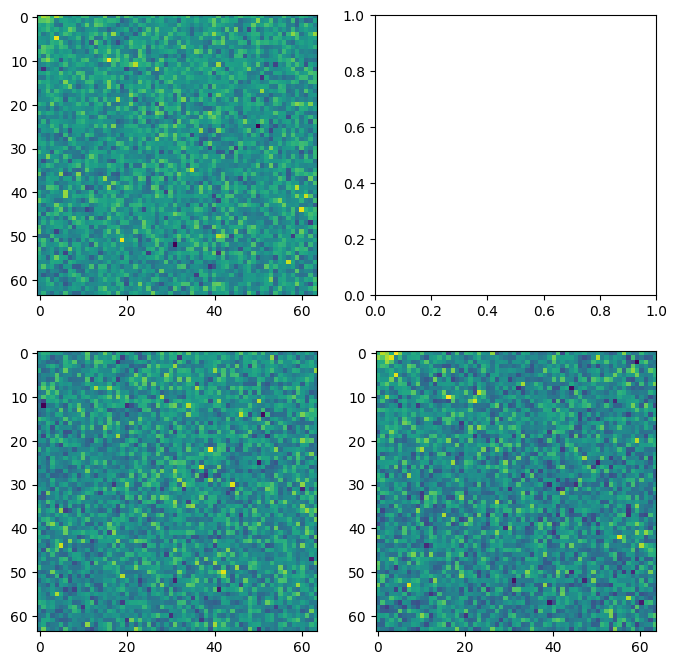

In [15]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [16]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

if disable_stochasticity is True:
    print('Disabling stochasticity in the model for coverage computation')
    model.non_stochastic_version = True

In [18]:
import torch.nn as nn 
class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)[0]

    def normalize_target(self, x):
        return self.model.normalize_target(x)

singleoutput_model = NnModel(model).cuda()

100%|██████████| 50/50 [00:00<00:00, 73.31it/s]


Best t value: 0.44


loss: 0.292, alpha_dyn: 1.248, beta_dyn: 0.042, sigma_dyn: 0.001, std_loss: 0.012 poisson_loss: 3.428 alpha_poisson: 1.602 beta_poisson: 0.003: 100%|██████████| 6000/6000 [00:38<00:00, 157.67it/s] 


Learned parameters: alpha, beta, sigma 1.2483292818069458 0.041865114122629166 0.0009645487298257649 1.6024032831192017 0.002675551688298583
1509
809
1001
Transforms for Ch1: [('identity', {}), ('translate', {})]
Transforms for Ch2: [('identity', {}), ('translate', {})]
Using correlation preserving transforms
Using transform types: {0: [Identity(transform_type='identity'), Translate(transform_type='translate')], 1: [Identity(transform_type='identity'), Translate(transform_type='translate')]}


Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}
[PosteriorSampler] k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.33999999999999997, 0.54], mu

100%|██████████| 53/53 [00:14<00:00,  3.68it/s]


Offset based on background quantile 0.43621013
Offset based on background quantile 0.35748821
Starting the grid search
0.67 10 D0
2.34 20 D0
4.77 30 D0
7.63 40 D0
Upscaling 10 -> 20
10.89 50 D0
17.22 70 D0
23.31 90 D0
28.94 110 D0
Upscaling 20 -> 40
33.93 130 D0
42.31 170 D0
48.68 210 D0
53.91 250 D1
48.68 210 D2
51.37 230.0 D3
50.10 220.0 D3
49.41 215.0 D4
50.10 220.0 D5
49.74 217.5 D6
49.90 218.75 D6
49.99 219.375 D6
50.10 220.0 D7
Using 42.31 percentile for 50, Factor:210 Error:5.82723460589778

Starting the grid search
1.00 10 D0
3.09 20 D0
4.96 30 D0
6.71 40 D0
Upscaling 10 -> 20
8.26 50 D0
10.72 70 D0
12.78 90 D0
14.57 110 D0
Upscaling 20 -> 40
16.27 130 D0
19.01 170 D0
21.34 210 D0
23.34 250 D0
Upscaling 40 -> 80
25.21 290 D0
28.69 370 D0
31.90 450 D0
34.94 530 D0
Upscaling 80 -> 160
37.58 610 D0
42.59 770 D0
46.86 930 D0
50.79 1090 D1
46.86 930 D2
48.85 1010.0 D2
49.85 1050.0 D2
50.79 1090.0 D3
49.85 1050.0 D4
50.34 1070.0 D5
50.09 1060.0 D5
49.97 1055.0 D6
50.09 1060.0 D7
Usin

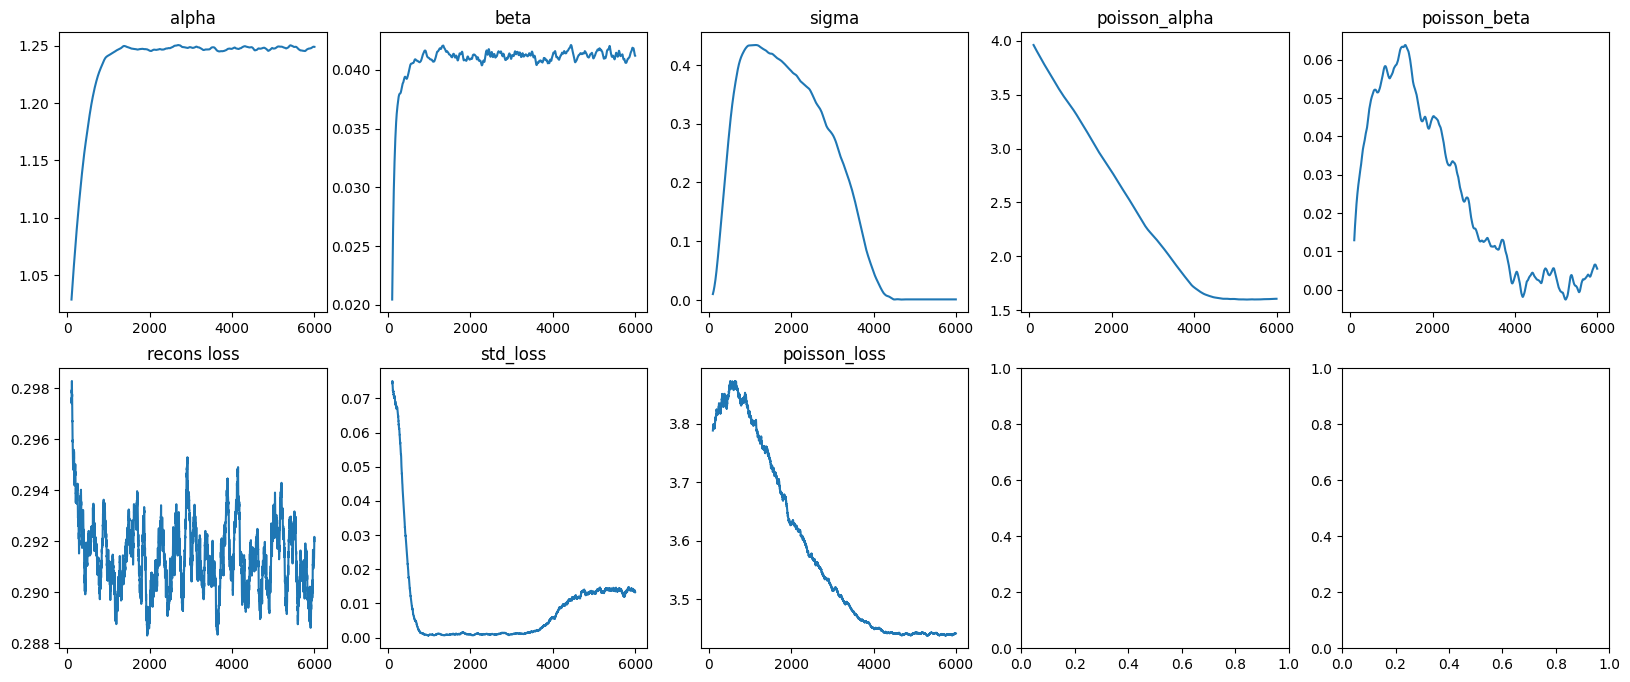

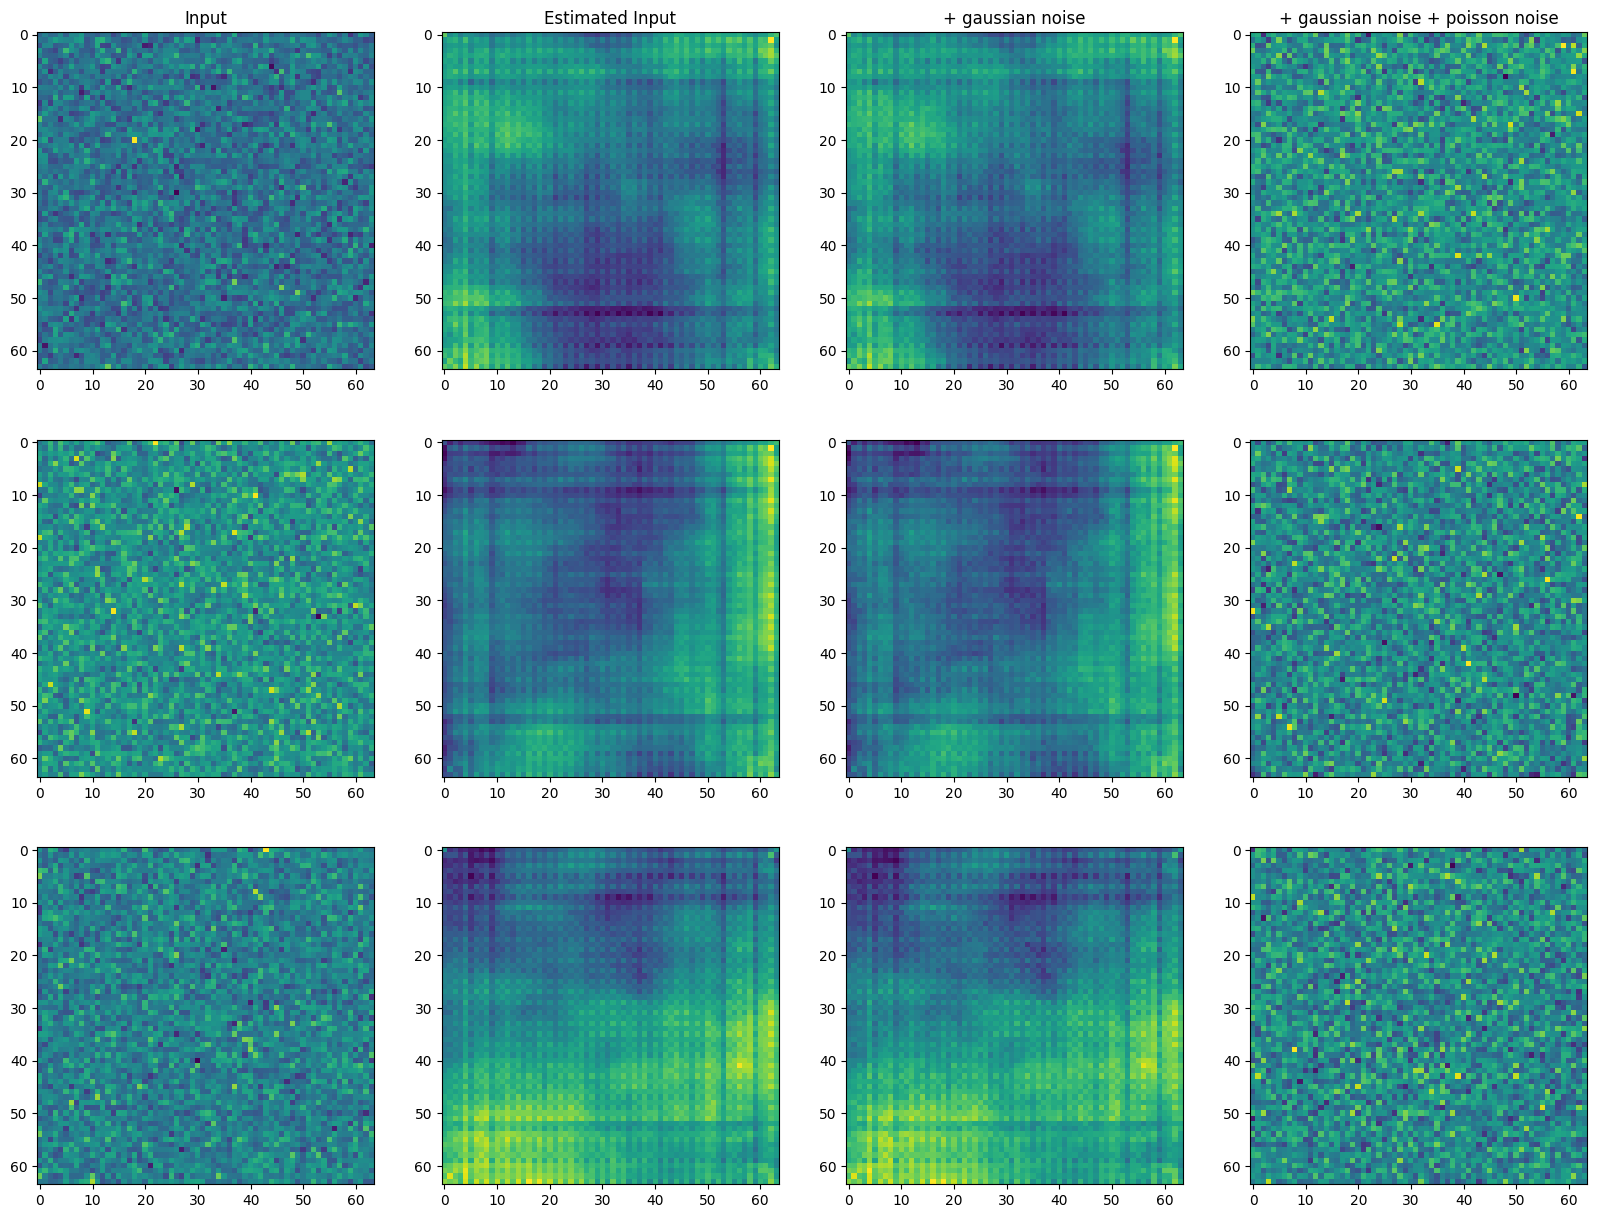

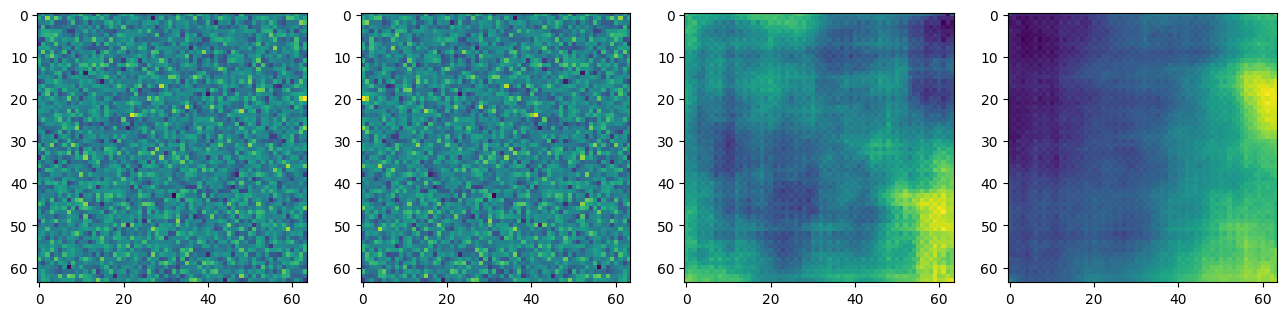

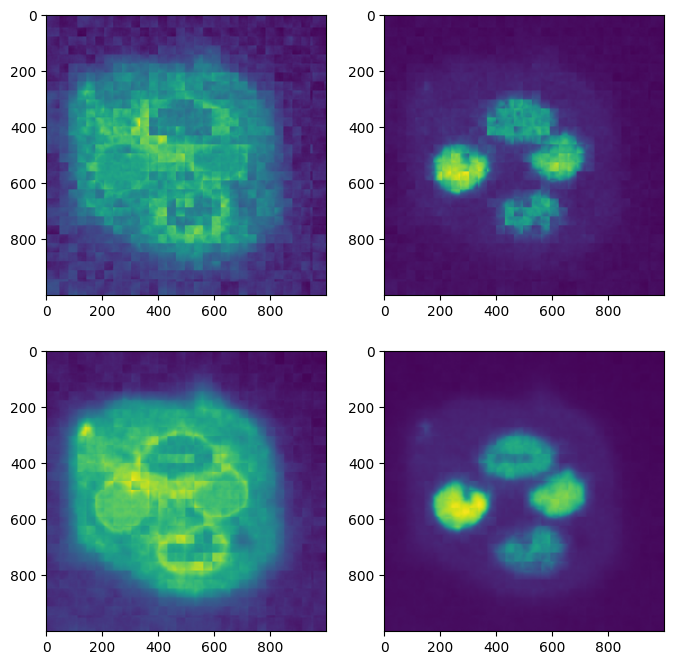

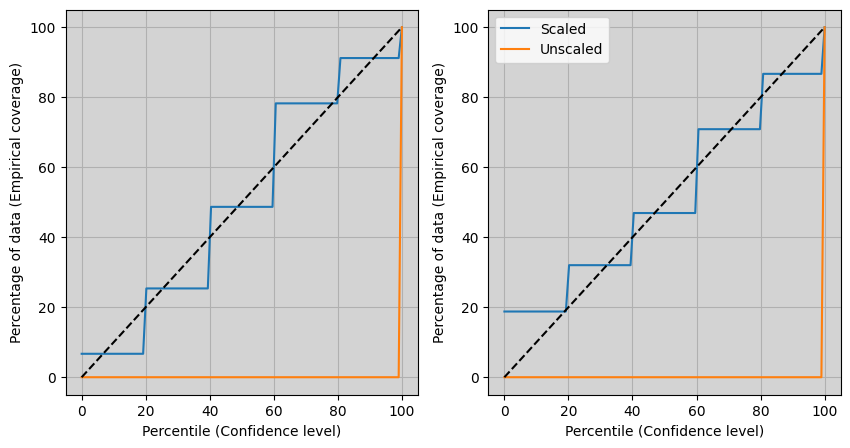

In [ ]:
# uq_processor.quantify()
from finetunesplit.posterior_sampler import PosteriorSampler
from finetunesplit.calibration.find_optimal_parameters import find_optimal_params
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.uq_quantification import UncertaintyQuantification
from disentangle.core.psnr import RangeInvariantPsnr

uq_processor = UncertaintyQuantification(singleoutput_model, train_dset, val_dset, metric_func_for_mixingratio=RangeInvariantPsnr, stitch_function=stitch_predictions)
plot = True
homography_transform_params = None
if enable_homography_transform:
    homography_transform_params = {'theta_max':aug_theta_max, 'theta_z_max':aug_theta_z_max, 'shift_max':aug_shift_max, 'device': 'cuda'}
    print('Enabling homography transform', homography_transform_params)

mixing_t_delta = 0.1
transforms_config = {
    'correlation_preserving_transforms': corr_pres_trans,
    'with_pred_transforms': with_transforms,
    'with_inp_transforms': with_inp_transforms,
    'enable_translation_transform': enable_translation_transform,
    'homography_transform_params': homography_transform_params,
    'enable_percentile_evaluation': enable_percentile_evaluation
}
err_and_var_config = {
    'percentiles_to_evaluate':[10,20,30,40,50,60,70,80,90],
    'skip_pixels': skip_pixels_err_var_computation,
    'elem_size': elem_size,
    'compute_error_from_first_prediction': compute_error_from_first_prediction
}


pred_dict = uq_processor.get_input_tar_pred(uq_processor._val, uq_processor.model, batch_size=batch_size, mmse_count=mmse_count, num_workers=num_workers)
        
# get optimal mixing ratio from input and predictions
mixing_t_pred = uq_processor.optimal_mixing_ratio(pred_dict['inp'], pred_dict['pred'])
print('Obtained optimal mixing t from predictions:', mixing_t_pred)

# get estimated input patches
estimated_inp_patches = uq_processor.get_estimated_inp(pred_dict['pred'], mixing_t_pred)
normalized_inp_patches = pred_dict['inp']

# use estimated input patches to learn noise parameters
noise_params = uq_processor.estimate_input_noise_params(normalized_inp_patches, estimated_inp_patches, plot=plot)

# now, we have the forward operator parameters
forward_operator_params = uq_processor.get_forward_operator_params(mixing_t_pred, mixing_t_delta, noise_params)

# get transforms
transform_dict = uq_processor.get_transforms(correlation_preserving_transforms=transforms_config['correlation_preserving_transforms'], 
                with_pred_transforms=transforms_config['with_pred_transforms'], 
                with_inp_transforms=transforms_config['with_inp_transforms'], 
                enable_translation_transform=transforms_config['enable_translation_transform'], 
                homography_transform_params=transforms_config['homography_transform_params'],
                enable_percentile_evaluation=transforms_config['enable_percentile_evaluation'])

# instantiate the sampler
psampler = PosteriorSampler(uq_processor.model, transform_dict['pred_transform'], 
                                forward_operator_params=forward_operator_params, 
                                mmse_count=mmse_count,
                                k_forward_pass=k_forward_pass, input_transforms=transform_dict['inp_transform'], 
                                keep_original_input_fraction=keep_original_input_fraction)

_ = uq_processor.test_sampler(psampler, plot=plot)

# now, get err and var
err, var, pred_b, one_step_pred_mmse = uq_processor.get_err_and_var(uq_processor.model, psampler, batch_size=batch_size, num_workers=num_workers, uq_params=err_and_var_config)
if plot:
    uq_processor.plot_err_var(pred_b, one_step_pred_mmse, var, err)


output, metadata = find_optimal_params(err, var, percentiles_to_evaluate=err_and_var_config['percentiles_to_evaluate'], q_bkg=background_quantile, around_center=False)
factors_shifted, offsets_shifted = output
print('Optimal factors:', factors_shifted)
print('Optimal offsets:', offsets_shifted)

q_var = metadata['q_var']
q_err = metadata['q_err']

data_left_oriented = plot_coverage_plot( var -np.array(q_var)[None,:,None], 
                                    err, factors_shifted, [k+q_err[i] for i,k in enumerate(offsets_shifted)], 
                                    around_center=False)

perfect = np.linspace(0,100,100)
mean_err_arr = []
max_err_arr = []
for col_idx in range(var.shape[1]):
    act = data_left_oriented[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    mean_err_arr.append(mean_err)
    max_err_arr.append(max_err)
    print(f'LeftOriented: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')
